In [2]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.collections import PatchCollection

import random

#python scripts\visualize.py solution-ins-12.txt

def visualize(w, l, n, dims, coords):
    coordsX = [coords[i][0] for i in range(n)]
    coordsY = [coords[i][1] for i in range(n)]
    # print(w, l, n, dims, coordsX, coordsY)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.xlim(0, w)
    plt.ylim(0, l)
    plt.grid(True, color='black')

    myPatches = []
    # myColors = []

    for i in range(n):
        xi_hat = coordsX[i]
        yi_hat = coordsY[i]
        xi = dims[i][0]
        yi = dims[i][1]

        r = patches.Rectangle((xi_hat, yi_hat), xi, yi)
        myPatches.append(r)

    collection = PatchCollection(myPatches, cmap=mpl.cm.hsv, alpha=0.5, edgecolor='black', linewidth=4)
    collection.set_array(np.linspace(0, 254, n, dtype=int))
    #print(np.linspace(0, 200, n, dtype=int))
    collection.set_clim([0, 255])
    ax.add_collection(collection)

    plt.xticks(range(w+1))
    plt.yticks(range(l+1))

    plt.gca().set_aspect('equal', adjustable='box')

    # fig.savefig('figure.png')
    plt.show()

In [109]:
w = 8
n = 4
dims = [[3, 3],
        [3, 5],
        [5, 3],
        [5, 5]]
"""w = 4
n = 2
dims = [[3, 3],
        [3, 5]]"""
dimsX = [dims[i][0] for i in range(n)]
dimsY = [dims[i][1] for i in range(n)]

In [110]:
print(dimsX)
print(dimsY)

[3, 3, 5, 5]
[3, 5, 3, 5]


In [5]:
from z3 import *
from itertools import combinations

In [6]:
def at_least_one(B):
    return Or(B)
def at_most_one(B, name=''):
    return And( [Not(And(pair[0], pair[1])) for pair in combinations(B, 2)] )
    # List which will contain all the formulas for the at_most_one constraint
    """formulas_list = []
    
    n = len(B)  # Number of variables
    
    # Defining the new variables (Note: the indeces start from 0)
    s = [Bool(f's_{name}_{i}') for i in range(n-1)]
    
    # LET'S ADD THE FORMULAS, ONE AT A TIME
    
    # First formula
    formulas_list.append( Or(Not(B[0]), s[0]) )
    
    # Second formula
    formulas_list.append( Or(Not(B[n-1]), Not(s[n-2])) )
    
    # Third big formula
    for i in range(1, n-1):
        formula = And( Or(Not(B[i]),s[i]), Or(Not(s[i-1]),s[i]), Or(Not(B[i]),Not(s[i-1])) )
        formulas_list.append(formula)
        
    # Return the conjunction among all the added formulas
    return And(formulas_list)"""
def exactly_one(B, name=''):
    return And(at_least_one(B), at_most_one(B, name=name))

In [7]:
class UnsatError(BaseException):
    pass

In [204]:
def __vlsi_sat(w, n, dimsX, dimsY, w_min, h_min, l_min, l_max):

    s = Solver()  # Solver instance
    
    # Upper bound of the length of the plate, if not explicitely given in input
    # l_max = sum(dimsY)
    
    # List of lists of lists, containing the 'circuits' boolean variables: variables 'circuit_i_j_k'
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max-h_min+1)] for i in range(w-w_min+1)]
    # List of lists of lists, containing the 'coords' boolean variables: variables 'coord_i_j_k'
    # coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max-h_min+1)] for i in range(w-w_min+1)]
    # List of lists of lists, containing the 'lengths' boolean variables: variables 'length_k_l'
    lengths = [[Bool(f'length_{k}_{l}') for l in range(l_max-l_min+1)] for k in range(n)]
    
    # Constraint: in each cell '(i,j)' of the plate at most one circuit is present.
    # This reflects both on `circuits` and on `coords`.
    for i in range(w-w_min+1):
        for j in range(l_max-h_min+1):
            s.add(at_most_one(circuits[i][j], name=f'at_most_one_circuit_{i}_{j}'))  # TODO : redundant?
            #s.add(at_most_one(coords[i][j], name=f'at_most_one_coord_{i}_{j}'))
            
    # Constraint: the left-bottom corner of each circuit 'k' must be present exactly one time across the plate
    #for k in range(n):
    #    s.add(exactly_one([coords[i][j][k] for i in range(w-w_min+1) for j in range(l_max-h_min+1)], name=f'exactly_one_{k}'))

    print('CUCU')  # TODO: remove

    # Constraint: for each circuit 'k' and for each cell '(i,j)' of the plate, if that cell contains the left-bottom corner 
    # of 'k', then all the cells covered by the circuit 'k' must contain only that circuit and no other circuits.      
    for k in range(n):
        formulas = []
        for i in range(w-w_min+1):
            for j in range(l_max-h_min+1):
                # Current iteration: circuit `k` and cell `(i,j)` of the plate.
                # Now the constraint about putting the left-bottom corner of `k` in `(i,j)` is ensured.

                # Case in which `k` can't be put in `(i,j)`, because it goes out of the bounds of the plate.
                # In such case, a constraint ensuring that `k` can't be put in `(i,j)` is esnured.
                if i+dimsX[k]-1>=w or j+dimsY[k]-1>=l_max:
                #    s.add(Not(coords[i][j][k]))  # The left-bottom corner of `k` can't be put in `(i,j)`
                    #covered_positions = [(i+ii,j+jj) for ii in range(1,dimsX[k]) for jj in range(1,dimsY[k])
                                                     #if i+ii-1<w and j+jj- ]
                    #s.add(And([Not(circuits[ii][jj][k]) for (ii,jj) in covered_positions]))
                    continue
                
                # List of tuples, representing the coordinates of the cells of the plate covered by the circuit
                covered_positions = [(i+ii,j+jj) for ii in range(dimsX[k]) for jj in range(dimsY[k])
                                                 if i+ii<w-w_min+1 and j+jj<l_max-h_min+1]
                non_covered_positions = list(set([(ii,jj) for ii in range(w-w_min+1) for jj in range(l_max-h_min+1)]) 
                                             - set(covered_positions))
                #non_covered_positions = [(ii,jj) for ii in range(w) for jj in range(l_max) if (ii,jj) not in covered_positions]
                print('cov', covered_positions)
                print('non-cov', sorted(non_covered_positions))

                # Formula ensuring that no other circuit is present in the `covered_positions`
                #no_overlapping_circuit_formula = And([Not(circuits[ii][jj][kk]) 
                #                                      for (ii,jj) in covered_positions for kk in range(n) if kk!=k])
                # Formula ensuring that all the `covered_positions` actually contain that circuit `k`
                all_positions_covered_formula = And([circuits[ii][jj][k] for (ii,jj) in covered_positions])                
                all_positions_not_covered_formula = And([Not(circuits[ii][jj][k]) for (ii,jj) in non_covered_positions])
                #formulas.append(And(all_positions_covered_formula,all_positions_not_covered_formula))
                #formulas.append(all_positions_covered_formula)
                
                # TODO: put negation of all circuits[ii][jj][k] related to wrong positions? 
                # The added constraint is the following implication: if left-bottom corner of `k` in `(i,j)`, then 
                # `no_overlapping_circuit_formula` and `all_positions_covered_formula`.
                # Actually, it is not an implication, nut an equivalence.
                #s.add(coords[i][j][k] == And(no_overlapping_circuit_formula,all_positions_covered_formula))

                # Formula ensuring that all the lengths up to `j+dimsY[k]-1` are used by the circuit `k`
                used_lengths_formula = And([lengths[k][l] for l in range(j+dimsY[k]-l_min+1)])
                # Formula ensuring that all the lengths from `j+dimsY[k]` are not used by the circuit `k`
                non_used_lengths_formula = And([Not(lengths[k][l]) for l in range(j+dimsY[k]-l_min+1, l_max-l_min+1)])
                # The added constraint is the following implication: if left-bottom corner of `k` in `(i,j)`, then 
                # `used_lengths_formula` and `non_used_lengths_formula`.
                #s.add(Implies(coords[i][j][k], And(used_lengths_formula, non_used_lengths_formula)))
                formulas.append(And(all_positions_covered_formula,all_positions_not_covered_formula,used_lengths_formula,
                                   non_used_lengths_formula))
        s.add(exactly_one(formulas, name=f'exactly_one_{k}'))
        #s.add(Or(formulas))
        print()

    print('HERE')  # TODO: remove

    # Check if UNSAT 
    if s.check() != sat:
        raise UnsatError('UNSAT')
        
    """m = s.model()
    
    coords = []
    for k in range(n):
        coord = min([(i,j) for i in range(w-w_min+1) for j in range(l_max-h_min+1) if m.evaluate(circuits[i][j][k])])
        print(coord)
        coords.append(coord)"""
        
    return s, circuits, lengths

In [184]:
from math import ceil

dimsX = [dims[i][0] for i in range(n)]
dimsY = [dims[i][1] for i in range(n)]

areas = [dimsX[i]*dimsY[i] for i in range(n)]  # The areas of the circuits
A_tot = sum(areas)  # The overall area of all the given circuits
h_min = min(dimsY)  # The minimum height of a circuit
h_max = max(dimsY)  # The maximum height of a circuit
w_min = min(dimsX)  # The minimum width of a circuit
w_max = max(dimsX)  # The maximum width of a circuit
l_min = max([h_max, A_tot // w])  # The lower bound for the length
min_rects_per_row = w // w_max  # Minimum number of circuits per row
max_rects_per_col = ceil(n / max([1, min_rects_per_row]))  # Maximum number of circuits per column
# The upper bound for the length
#l_max =  sum(sorted(dimsY)[n-max_rects_per_col:])
sorted_dimsY = sorted(dimsY, reverse=True)
l_max = sum([sorted_dimsY[i] for i in range(n) if i % min_rects_per_row == 0])

In [193]:
l_max

16

In [194]:
s, circuits, lengths = __vlsi_sat(w, n, dimsX, dimsY, w_min, h_min, l_min, l_max)

CUCU
cov [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
non-cov [(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
non-cov [(0, 0), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 4),

cov [(3, 4), (3, 5), (3, 6), (4, 4), (4, 5), (4, 6), (5, 4), (5, 5), (5, 6)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 1), (3, 2), (3, 3), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 0), (4, 1), (4, 2), (4, 3), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 5), (5, 6), (5, 7)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10),


cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)]
non-cov [(0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
non-cov [(0, 0), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2,

cov [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), 


cov [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2)]
non-cov [(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3)]
non-cov [(0, 0), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)

cov [(3, 2), (3, 3), (3, 4), (4, 2), (4, 3), (4, 4), (5, 2), (5, 3), (5, 4)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 1), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 0), (4, 1), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(3, 3), (3, 4), (3, 5), (4, 3), (4, 4), (4, 5), (5, 3), (5, 4), (5, 5)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10),

cov [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
non-cov [(0, 0), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 0), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]
non-cov [(0, 0), (0, 1), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), 


HERE
(3, 5)
(2, 0)
(3, 8)
(0, 11)


In [187]:
"""m = s.model()
coords = []
for k in range(n):
    for i in range(w):
        for j in range(l_max):
            if m.evaluate(circuits[i][j][k]):
                coords.append((i,j))
                break
        else:
            continue
        break

for k in range(n):
    coord = min([(i,j) for i in range(w-w_min+1) for j in range(l_max-h_min+1) if m.evaluate(circuits[i][j][k])])
    print(coord)
    coords.append(coord)"""

'm = s.model()\ncoords = []\nfor k in range(n):\n    for i in range(w):\n        for j in range(l_max):\n            if m.evaluate(circuits[i][j][k]):\n                coords.append((i,j))\n                break\n        else:\n            continue\n        break\n\nfor k in range(n):\n    coord = min([(i,j) for i in range(w-w_min+1) for j in range(l_max-h_min+1) if m.evaluate(circuits[i][j][k])])\n    print(coord)\n    coords.append(coord)'

In [196]:
coords

[(3, 5), (2, 0), (3, 8), (0, 11)]

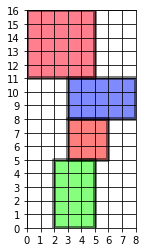

In [197]:
visualize(w, sum(dimsY), n, dims, coords)

In [216]:
def process_solver_instance(s, circuits, lengths, w, n, w_min, h_min, l_min, l_max, current_best_l):
    """Processes the given solver instance.

    Two operations are performed:
        - the new solution is extracted from the given solver;
        - additional constraints are injected into the solver, in order to find the next best solution (incremental solving).

    Parameters
    ----------
    s : z3.z3.Solver
        Solver instance
    coords : list of list of list of z3.z3.BoolRef
        Boolean variables 'coord_i_j_k'.
    lengths : list of list of z3.z3.BoolRef
        Boolean variables 'length_k_l'.
    w : int
        Width of the plate
    n : int
        Number of circuits
    l_max : int
        Upper bound of the length of the plate
    current_best_l : int
        Current best length of the plate (found so far)

    Returns
    -------
    coords_sol : list of tuple of int
        Coordinates of the left-bottom corner of the circuits of the new solution
    l : int
        Length of the plate of the new solution
    """
    if not current_best_l:
        current_best_l = l_max+1
    
    # Get the solution
    m = s.model()
    
    coords_sol = []    
    for k in range(n):
        coord = min([(i,j) for i in range(w-w_min+1) for j in range(l_max-h_min+1) if m.evaluate(circuits[i][j][k])])
        # print(coord)
        coords_sol.append(coord)
    print(coords_sol)

    # List containing the coordX and coordY of the lower-left vertex of each circuit
    # coords_sol = [(i, j) for k in range(n) for j in range(l_max-h_min+1) for i in range(w-w_min+1) if m.evaluate(coords[i][j][k])]
    # Boolean formula containing the solution
    # formula = And([ (coords[i][j][k] if m.evaluate(coords[i][j][k]) else Not(coords[i][j][k])) 
                  #for i in range(w-w_min+1) for j in range(l_max-h_min+1) for k in range(n)])

    # Length of the plate
    #print(type(lengths[0][0]))
    #print(lengths[0][0])
    l = max([l for k in range(n) for l in range(l_max-l_min+1) if m.evaluate(lengths[k][l])])+l_min-1+1
    
    # Add into the solver the negation of the returned `formula`, which represents the current solution.
    # In this way, in the next iteration, the same solution is not feasible anymore
    #s.add(Not(formula))  

    # Add into the solver a constraint ensuring that a solution which has a length bigger or equal than `l-2` is not feasible
    # anymore: in this way, the next found solution, if any, is for sure better than the previous one.
    # This is implemented by ensuring that all the variables 'lengths_k_ll' with 'll' from 'l-1' (included) to 
    # 'current_best_l-1' (exclued) are False.
    s.add(And([Not(lengths[k][ll]) for k in range(n) for ll in range(l-1-l_min+1,current_best_l-1-l_min+1)]))
    
    return coords_sol, l

In [217]:
import time

def vlsi_sat(w, n, dims, timeout=300):
    """Solves the given VLSI instance using a SAT encoding.

    It performs optimization: the best solution is returned (if any).
    More precisely, the best solution found strictly within the time limit is returned (if any).

    The implementation is based on the usage of the `__vlsi_sat` auxiliary function.
    Basically, a loop iterating over all the possible solutions is performed, searching for the best possible solution.

    Parameters
    ----------
    w : int
        The width of the plate
    n : int
        The number of circuits
    dims : list of tuple of int
        Dims X and Y (i.e. width and height) of the circuits
    timeout : int, optional
        Time limit in seconds for executing the SAT solver, by default 300 (i.e. 5 minutes)

    Returns
    -------
    best_coords: list of tuples of int
        List containing the coordX and coordY of the lower-left vertex of each circuit in the best solution
    best_l: int
        Length of the plate in the best solution

    Raises
    ------
    UnsatError
        If the given instance is UNSAT in the specified time limit.

    Notes
    ------
    Remarks about the time limit.
    It may happen that the user has to wait a bit longer than the specified time limit. (Basically, for recognizing the 
    exceeding of the time limit, the solver has to terminate).
    However, it is guaranteed that the returned solution has been found strictly within the time limit.
    """
    start_time = time.time()

    # Split `dims` into `dimsX` and `dimsY`
    dimsX = [dims[i][0] for i in range(n)]
    dimsY = [dims[i][1] for i in range(n)]

    areas = [dimsX[i]*dimsY[i] for i in range(n)]  # The areas of the circuits
    A_tot = sum(areas)  # The overall area of all the given circuits
    h_min = min(dimsY)  # The minimum height of a circuit
    h_max = max(dimsY)  # The maximum height of a circuit
    w_min = min(dimsX)  # The minimum width of a circuit
    w_max = max(dimsX)  # The maximum width of a circuit
    l_min = max([h_max, A_tot // w])  # The lower bound for the length
    min_rects_per_row = w // w_max  # Minimum number of circuits per row
    max_rects_per_col = ceil(n / max([1, min_rects_per_row]))  # Maximum number of circuits per column
    # The upper bound for the length
    #l_max =  sum(sorted(dimsY)[n-max_rects_per_col:])
    sorted_dimsY = sorted(dimsY, reverse=True)
    l_max = sum([sorted_dimsY[i] for i in range(n) if i % min_rects_per_row == 0])

    """# l_max = sum(dimsY)
    # Define the upper bound for the length of the plate
    w_max = max(dimsX)
    min_rects_per_row = w // w_max  # Minimum number of circuits per row
    max_rects_per_col = ceil(n / max([1, min_rects_per_row]))  # Maximum number of circuits per column
    # The upper bound for the length
    #l_max =  sum(sorted(dimsY)[n-max_rects_per_col:])
    sorted_dimsY = sorted(dimsY, reverse=True)
    l_max = sum([sorted_dimsY[i] for i in range(n) if i % min_rects_per_row == 0])"""
    
    # Search for a first solution 
    s, circuits, lengths = __vlsi_sat(w, n, dimsX, dimsY, w_min, h_min, l_min, l_max)
    best_coords, best_l = process_solver_instance(s, circuits, lengths, w, n, w_min, h_min, l_min, l_max, current_best_l=None)

    solving_time = time.time() - start_time
    if solving_time>timeout:  # The first solution has been found after the time out: no found solution
        raise UnsatError('UNSAT')

    # A first solution has been found

    print(best_coords)
    print(best_l)
       
    # Loop iterating over all the possible solutions, searching for the best one
    while True:
        if s.check()!=sat:  # No more solutions: break the cycle
            break

        # A new solution has been found

        solving_time = time.time() - start_time
        if solving_time>timeout:  # The new solution has been found after the time out: no valid solution. Break the cycle
            break

        # New valid solution

        # Get the new valid solution and inject the new constraints into the solver
        best_coords, best_l = process_solver_instance(s, circuits, lengths, w, n, w_min, h_min, l_min, l_max, best_l)        
        print(best_coords)
        print(best_l)
    
    # Return the best found solution. 
    # (For sure one solution has been found, however it can be non-optimal due to the timeout).
    return best_coords, best_l

In [218]:
best_coords, best_l = vlsi_sat(w, n, dims, timeout=300)

CUCU
cov [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
non-cov [(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
non-cov [(0, 0), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 4),

cov [(3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10),


cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)]
non-cov [(0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
non-cov [(0, 0), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2,

cov [(3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 13), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 13)]
cov [(3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 


cov [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2)]
non-cov [(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3)]
non-cov [(0, 0), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10)

cov [(2, 10), (2, 11), (2, 12), (3, 10), (3, 11), (3, 12), (4, 10), (4, 11), (4, 12), (5, 10), (5, 11), (5, 12)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 13), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 13), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 13)]
cov [(2, 11), (2, 12), (2, 13), (3, 11), (3, 12), (3, 13), (4, 11), (4, 12), (4, 13), (5, 11), (5, 12), (5, 13)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 


cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
non-cov [(0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13)]
cov [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
non-cov [(0, 0), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13),

cov [(3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 11), (3, 12), (3, 13), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 11), (4, 12), (4, 13), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 11), (5, 12), (5, 13)]
cov [(3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11)]
non-cov [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (1, 0), (1, 1), (1, 2), (1, 3), (1

In [219]:
best_coords

[(0, 0), (0, 3), (3, 5), (3, 0)]

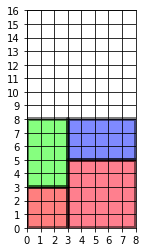

In [220]:
visualize(w, sum(dimsY), n, dims, best_coords)